<h1><center>Pokemon: Entendendo a relação entre HP e outros status para cada criatura</center></h1>

O objetivo desse notebook é o de entender se existe alguma relação entre a variável de HP (Health Points, pontos de vida) e as outras demais variáveis para cada um dos 150 pokemons iniciais. Para entender a relação entre as variáveis são utilizados os métodos de análise regressiva linear simples e multipla. A ideia do notebook é a de fixar o conhecimento sobre análise regressiva, mas também ensinar e ajudar quem esteja tentando entender o tópico. 
A base de dados utilizada está disponível no Kaggle, pelo link: https://www.kaggle.com/datasets/rounakbanik/pokemon

<h3>1.  Importando as bibliotecas e preparando a base</h3>

In [2]:
#Importando Bibliotecas

%matplotlib inline
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype, is_numeric_dtype
import seaborn as sns
#import statsmodels.api as sm
from sklearn.linear_model import LinearRegression


In [3]:
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('Pokemon.csv')

Checando o head do dataframe e as colunas contidas nele

In [5]:
df.head()

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


In [6]:
df.columns

Index(['abilities', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic',
       'against_rock', 'against_steel', 'against_water', 'attack',
       'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate',
       'classfication', 'defense', 'experience_growth', 'height_m', 'hp',
       'japanese_name', 'name', 'percentage_male', 'pokedex_number',
       'sp_attack', 'sp_defense', 'speed', 'type1', 'type2', 'weight_kg',
       'generation', 'is_legendary'],
      dtype='object')

Embora seja possível incorporar quaisquer variáveis dessas no modelo, o trabalho aqui vai trabalhar com algumas dessas. Assim, o primeiro passo é criar um novo dataframe, apenas com as variáveis possivelmente úteis ao trabalho. Isso facilita a exploração dos dados e agiliza a leitura do código

In [7]:
data_pokemon = df[['attack', 'capture_rate', 'classfication', 'defense', 'height_m', 'hp', 'name', 'sp_attack', 'sp_defense', 'speed', 'type1', 'type2', 'weight_kg', 'generation', 'is_legendary']]
data_pokemon.head()

,attack,capture_rate,classfication,defense,height_m,hp,name,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,49,45,Seed Pokémon,49,0.7,45,Bulbasaur,65,65,45,grass,poison,6.9,1,0
1,62,45,Seed Pokémon,63,1.0,60,Ivysaur,80,80,60,grass,poison,13.0,1,0
2,100,45,Seed Pokémon,123,2.0,80,Venusaur,122,120,80,grass,poison,100.0,1,0
3,52,45,Lizard Pokémon,43,0.6,39,Charmander,60,50,65,fire,NaN,8.5,1,0
4,64,45,Flame Pokémon,58,1.1,58,Charmeleon,80,65,80,fire,NaN,19.0,1,0


Antes de tudo, é necessário verificar se a base tem valores nulos. Os valores nulos serão preenchidos com o valor da mediana de toda a coluna, visando não atrapalhar a leitura dos dados

In [11]:
data_pokemon.isnull().sum()

attack             0
capture_rate       0
classfication      0
defense            0
height_m          20
hp                 0
name               0
sp_attack          0
sp_defense         0
speed              0
type1              0
type2            384
weight_kg         20
generation         0
is_legendary       0
dtype: int64

In [16]:
for col in data_pokemon[['height_m', 'weight_kg']]:
    data_pokemon[col].fillna(data_pokemon[col].median(), inplace=True)

In [17]:
data_pokemon.isnull().sum()

attack             0
capture_rate       0
classfication      0
defense            0
height_m           0
hp                 0
name               0
sp_attack          0
sp_defense         0
speed              0
type1              0
type2            384
weight_kg          0
generation         0
is_legendary       0
dtype: int64

É preciso saber se as distribuições em cada uma das variáveis é normalizada, isso é, se obedece uma regularidade. O método mais fácil de descobrir se a variável é normalizada é fazendo um histograma, visto que uma variável normalmente distribuída vai mostrar um histograma aparentemente simétrico. Assim, são feitos histogramas para todas as variáveis numéricas


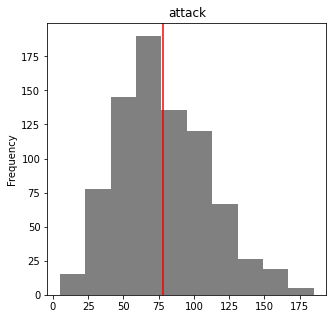

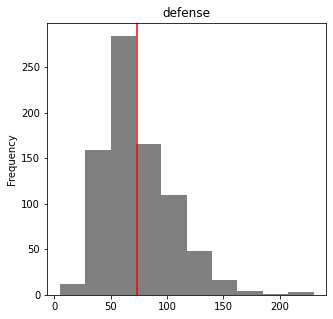

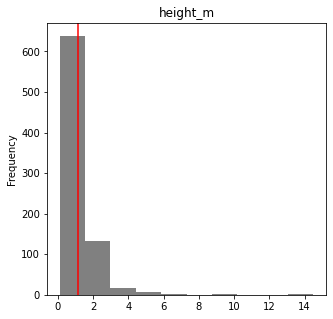

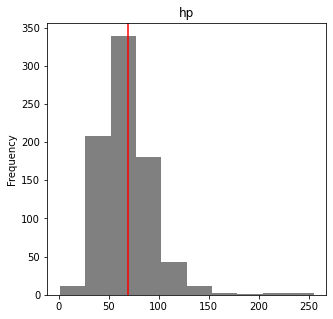

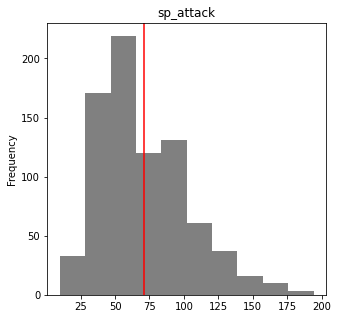

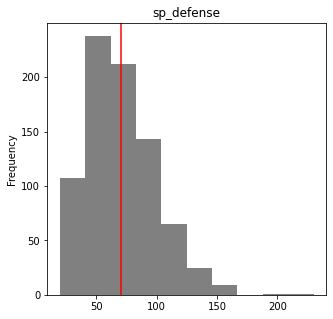

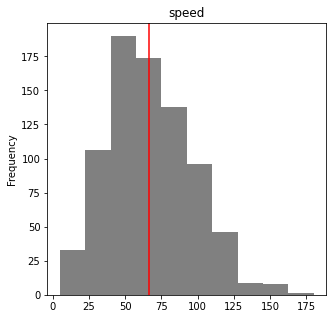

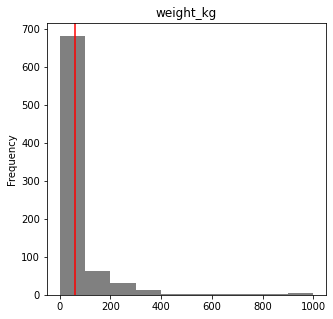

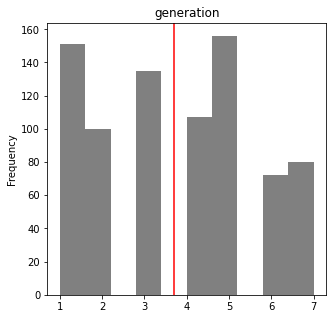

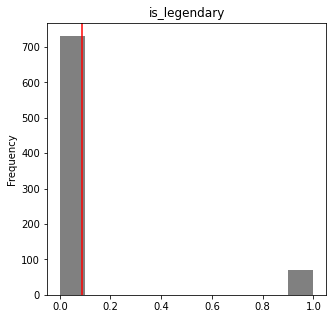

In [18]:
def generate_graphs(base):
    for col in base:
        if is_numeric_dtype(base[col]):
            plt.figure(col, figsize=(5, 5))
            plt.title(col)
            plt.axvline(base[col].mean(), color='red')
            base[col].plot(kind='hist', color='gray')
            

generate_graphs(data_pokemon)

Após a avaliação dos gráficos é possível perceber que a maioria deles é levemente assimetrico, no entanto, os outliers não vão prejudicar muito a leitura nesse caso. As únicas variáveis bruscamente assimetricas são as de peso e altura, assim, são criadas novas colunas com os valores logarítimicos de peso e altura

In [25]:
data_pokemon['log_weight'] = np.log(data_pokemon['weight_kg'])
data_pokemon['log_height'] = np.log(data_pokemon['height_m'])
#data_pokemon['log_def'] = np.log(data_pokemon['defense'])
#data_pokemon['log_hp'] = np.log(data_pokemon['hp'])
#Fiz essas duas últimas conversões e a distribuição não foi muito modificada, então as deixei de fora para facilitar a interpretação do modelo

<h3>2.  Estimando modelos de regressão linear</h3>

Com a base e as colunas devidamente ajustadas, é hora de começar a análise de regressão linear. O primeiro modelo é um modelo linear simples da função do HP em relação a defesa de cada monstro.

In [36]:
x1 = data_pokemon['defense'].values
y = data_pokemon['hp'].values

x1 = x1.reshape(-1, 1)
y = y.reshape(-1, 1)

regressao = LinearRegression()
modelo = regressao.fit(x1, y)

modelo.coef_
modelo.intercept_
regressao.score(x1, y)

0.05874717031313004

Nesse caso, o que o modelo diz é que cada aumento em 1 ponto de defesa aumenta cerca de 0.2093 pontos de HP, ou seja, cada 1 incremento em x aumentaria 0.2093 em y na nossa reta. Esse valor explica 5.8% da variável HP (R² = 0.058) e é significante porque o seu p-value é bem baixo.
Ainda assim, é possível associar mais variáveis ao modelo de regressão linear para tentar encontrar uma relação maior entre a constituição do HP e outros índices para cada caso; colocarei o peso do pokemon e a variável categórica que pergunta se ele é lendário ou não.

In [11]:
modelo2 = sm.OLS.from_formula('hp ~ defense + log_weight + is_legendary + log_height + speed + attack + sp_defense', data = data_pokemon)
resultado2 = modelo2.fit()
resultado2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     hp   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     68.48
Date:                Mon, 27 Jun 2022   Prob (F-statistic):           8.44e-77
Time:                        20:07:53   Log-Likelihood:                -3482.3
No. Observations:                 781   AIC:                             6981.
Df Residuals:                     773   BIC:                             7018.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       53.7571      4.396     12.230      0.000      45.129      62.386
defense         -0.1774      0.034     -5.267      0.000      -0.244      -0.111
log_weight       2.7113      0.857      3.163      0.002       1.028       4.394
is_legendary    15.5360      2.970      5.231      0.000       9.706      21.366
log_height      11.4531      1.960      5.844      0.000       7.606      15.300
speed           -0.0994      0.031     -3.233      0.001      -0.160      -0.039
attack           0.1645      0.032      5.189      0.000       0.102       0.227
sp_defense       0.1896      0.035      5.469      0.000       0.122       0.258
==============================================================================
Omnibus:                      462.739   Durbin-Watson:                   1.628
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6897.728
Skew:                           2.378   Prob(JB):                         0.00
Kurtosis:                      16.760   Cond. No.                         947.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Para esse modelo é importante notar que as variáveis peso e altura encontram-se em sua forma logarítimica, isso significa que cada 1% de incremento no peso do pokemon aumenta 0.0816 pontos no seu HP (8.16/100). Também é importante perceber que a variável "is_legendary" é uma variável categórica que aceita apenas os valores 0 e 1 (sim e não), logo, sua interpretação é a de que um pokemon lendário tem, em média, 21.53 HP a mais do que um pokemon não lendário, estando as demais variáveis controladas. Nesse modelo o valor da defesa pode ser desconsiderado, visto o alto valor de P. Essas variáveis explicam 34.1% do HP.

In [62]:
modelo3 = LinearRegression()

X1 = data_pokemon['defense'].values
Y = data_pokemon['hp'].values

X1 = X1.reshape(-1, 1)
Y = Y.reshape(-1, 1)

modelo3 = LinearRegression()
modelo3.fit(X1, Y)
#modelo3.intercept_
#modelo3.coef_


(801, 1)

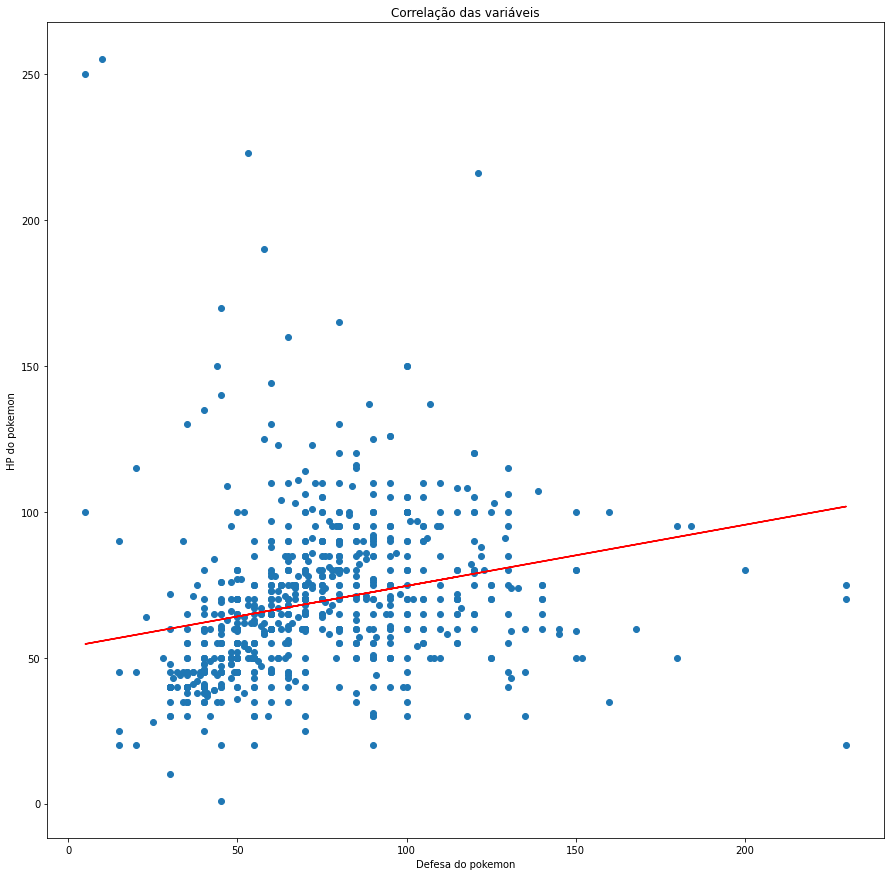

In [67]:
plt.figure(figsize=(15, 15))
plt.title('Correlação das variáveis')
plt.ylabel('HP do pokemon')
plt.xlabel('Defesa do pokemon')
ax_scatter = plt.scatter(X1, Y,)
plt.plot(X1, modelo3.predict(X1), color='red')
